In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import batman
from scipy import stats

pi = np.pi

In [2]:
# file names
dr25_file = '/Users/research/projects/alderaan/Catalog/kepler_q1_q17_thompson.csv'
q16_file = '/Users/research/projects/alderaan/Catalogu/kepler_q1_q16_mullally.csv'

# convenience function to read in csv file
def read_csv_file(filename, kindex, vindex):
    data = []
    with open(filename) as infile:
        reader = csv.reader(infile)

        for row in reader:
            data.append(row)

        keys   = data[kindex]
        values = data[vindex:]

            
        return keys, values


# READ IN DATA -- https://exoplanetarchive.ipac.caltech.edu
dr25_keys, dr25_data = read_csv_file(dr25_file, 53, 54)
q16_keys, q16_data = read_csv_file(q16_file, 53, 54)

In [3]:
# convenience functions to pull data from csv files
def getdata(keyname, keys, data):
    '''
    keyname = (string) of column definition, see CKS documentation
    '''
    kid = keys.index(keyname)
    
    outdata = []
    for row in data:
        outdata.append(row[kid])
    
    return outdata


# read dr25 data into a dictionary
dr25 = {}
for k in dr25_keys:
    dr25[k] = getdata(k, dr25_keys, dr25_data)
    
q16 = {}
for k in q16_keys:
    q16[k] = getdata(k, q16_keys, q16_data)

In [4]:
def check_lengths(data):
    keys = data.keys()
    k0   = list(keys)[0]
    L0   = len(data[k0])
    
    for k in keys:
        if len(data[k]) != L0:
            raise ValueError('inconsistent array lengths')
            
    return None


def convert_to_arrays(data):
    keys = data.keys()
    dnew = {}
    
    for k in keys:
        dnew[k] = np.asarray(data[k])
        
    return dnew       



# grab a reference key
dr25_k0 = list(dr25.keys())[0]
q16_k0 = list(q16.keys())[0]


# convert to arrays
dr25 = convert_to_arrays(dr25)
q16 = convert_to_arrays(q16)

print('total number of queried DR25 objects =', len(dr25[dr25_k0]))
print('total number of queries Q16 ovjects =', len(q16[q16_k0]))

check_lengths(dr25)
check_lengths(q16)

total number of queried DR25 objects = 8054
total number of queries Q16 ovjects = 7348


In [5]:
# remove false positives from DR25
fp = (dr25['koi_disposition'] != 'CONFIRMED')*(dr25['koi_disposition'] != 'CANDIDATE')

for k in dr25.keys():
    dr25[k] = dr25[k][~fp]

    
# remove false positives from Q16
fp = (q16['koi_disposition'] != 'CONFIRMED')*(q16['koi_disposition'] != 'CANDIDATE')

for k in q16.keys():
    q16[k] = q16[k][~fp]    

print('after removing false positives, DR25 objects =', len(dr25[dr25_k0]))
print('after removing false positives, Q16 objects =', len(q16[q16_k0]))

after removing false positives, DR25 objects = 4078
after removing false positives, Q16 objects = 3107


In [6]:
# cut DR25 low signal-to-noise objects (SNR < 7.1)
dr25_snr = dr25['koi_model_snr']
dr25_snr[dr25_snr == ''] = 0
dr25_snr = np.array(dr25_snr, dtype='float')

for k in dr25.keys():
    dr25[k] = dr25[k][dr25_snr >= 7.1]
    

# cut Q16 low signal-to-noise objects (SNR < 7.1)
q16_snr = q16['koi_model_snr']
q16_snr[q16_snr == ''] = 0
q16_snr = np.array(q16_snr, dtype='float')

for k in q16.keys():
    q16[k] = q16[k][q16_snr >= 7.1]
    

print('after cutting on SNR > 7.1, DR25 objects =', len(dr25[dr25_k0]))
print('after cutting on SNR > 7.1, Q16 objects =', len(q16[q16_k0]))

after cutting on SNR > 7.1, DR25 objects = 4033
after cutting on SNR > 7.1, Q16 objects = 3025


# Cross match and plot impact parameters

In [7]:
keep = dr25['koi_impact'] != ''

b_dr25 = np.array(dr25['koi_impact'][keep], dtype='float')
koi_dr25 = np.array(dr25['kepoi_name'])[keep]
snr_dr25 = np.array(dr25['koi_model_snr'][keep], dtype='float')


keep = q16['koi_impact'] != ''

b_q16 = np.array(q16['koi_impact'][keep], dtype='float')
koi_q16 = np.array(q16['kepoi_name'])[keep]
snr_q16 = np.array(q16['koi_model_snr'][keep], dtype='float')


In [8]:
match_dr25 = np.isin(koi_dr25, koi_q16)
match_q16 = np.isin(koi_q16, koi_dr25)

b_dr25 = b_dr25[match_dr25]
b_q16 = b_q16[match_q16]

koi_dr25 = koi_dr25[match_dr25]
koi_q16 = koi_q16[match_q16]

snr_dr25 = snr_dr25[match_dr25]
snr_q16 = snr_q16[match_q16]


In [9]:
dummy = []
for koi in koi_dr25:
    dummy.append(float(koi[1:]))
    
order = np.argsort(dummy)

b_dr25 = b_dr25[order]
koi_dr25 = koi_dr25[order]
snr_dr25 = snr_dr25[order]

In [10]:
dummy = []
for koi in koi_q16:
    dummy.append(float(koi[1:]))
    
order = np.argsort(dummy)

b_q16 = b_q16[order]
koi_q16 = koi_q16[order]
snr_q16 = snr_q16[order]

In [11]:
plt.style.use(["dark_background"])

SMALL_SIZE = 16
MEDIUM_SIZE = 20
LARGE_SIZE = 30

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE, frameon=False)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

plt.rc('axes', linewidth=2)

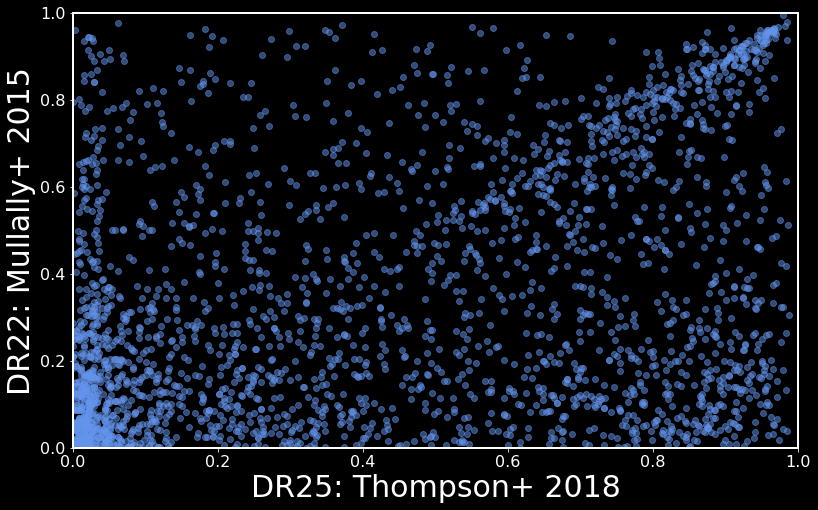

In [12]:
X = 0

plt.figure(figsize=(13,8))
plt.plot(b_dr25[snr_dr25 > X], b_q16[snr_dr25 > X], 'o', color='cornflowerblue', alpha=0.5)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks()
plt.yticks()
plt.xlabel('DR25: Thompson+ 2018')
plt.ylabel('DR22: Mullally+ 2015')
plt.savefig('/Users/research/Desktop/Impact_Comparison.pdf', bbox_inches='tight', transparent=True)
plt.show()

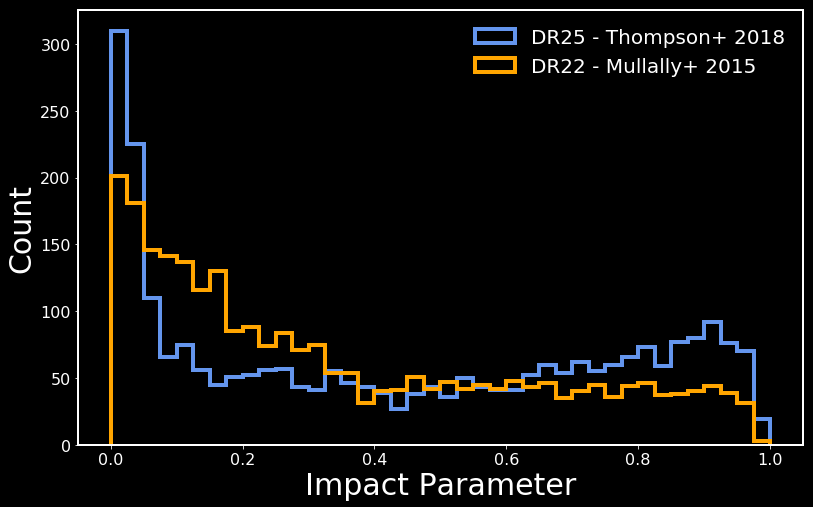

In [13]:
plt.figure(figsize=(13,8))
plt.hist(b_dr25, bins=np.arange(0,1.025,0.025), color='cornflowerblue', 
         histtype='step', lw=4, label="DR25 - Thompson+ 2018")
plt.hist(b_q16, bins=np.arange(0,1.025,0.025), color='orange', 
         histtype='step', lw=4, label="DR22 - Mullally+ 2015")
plt.xticks()
plt.yticks()
plt.xlabel("Impact Parameter")
plt.ylabel("Count")
plt.legend(loc="upper right")
plt.savefig('/Users/research/Desktop/Impact_histogram.pdf', bbox_inches="tight", transparent=True)
plt.show()

# Make $b-r_p$ plot

In [14]:
p = batman.TransitParams()

p.t0  = 0
p.per = 11.3
p.rp  = 0.035
p.a   = (p.per/365.24)**(2/3) * 215
p.b   = 0.0
p.ecc = 0.0
p.w   = 90.
p.u   = [0.4804, 0.1867]
p.limb_dark = "quadratic"


p.inc = np.arccos(p.b/p.a)*180/pi

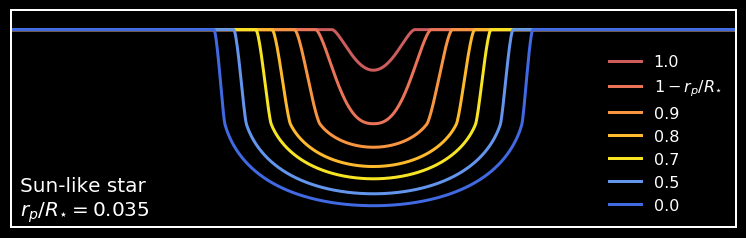

In [22]:
impacts = [1.0, 1-p.rp, 0.9, 0.8, 0.7, 0.5, 0.0]
depths = []
durs   = []

cmap = plt.cm.plasma
colors = ['indianred', cmap(0.65), cmap(0.75), cmap(0.85), cmap(0.95), 'cornflowerblue', 'royalblue']

plt.figure(figsize=(13,4))
   

for i, b in enumerate(impacts):
    p.b   = b
    p.inc = np.arccos(p.b/p.a)*180/pi

    t = np.linspace(-0.2, 0.2, 1000)

    m = batman.TransitModel(p, t)
    f = m.light_curve(p)
        
    depths.append(1-f.min())
    durs.append(t[np.max(np.where(f<1))] - t[np.min(np.where(f<1))])
    
    if i != 1:
        plt.plot(t, f, c=colors[i], label=b, lw=3, ls="-")
    else:
        plt.plot(t, f, c=colors[i], label="$1-r_p/R_{\star}$", lw=3, ls="-")
    #axes[1].plot(t/durs[i], 1+(f-1)/depths[i],  c=cmap(b), label=b)
    
plt.xlim(-0.2,0.2)
plt.ylim(0.9983,1.00017)
plt.text(-0.195, 0.998575, "Sun-like star", ha="left", va="bottom")
plt.text(-0.195, 0.998325, "$r_p/R_{\star} = 0.035$", ha='left', va='bottom')
plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])
plt.legend(fontsize=16, loc='lower right')
plt.savefig('/Users/research/Desktop/impact_transit_shapes.pdf', bbox_inches="tight", transparent=True)
plt.show()

# Show effects of TTVs & TDVs

In [23]:
import exoplanet as exo
import pymc3 as pm
import theano.tensor as T

from archeopteryx.constants import *

In [24]:
# set planet parameters
t0  = 4.1
per = 11.3
rp  = 0.035
b   = 0.5
u   = [0.4804, 0.1867]

Pttv = 100.
Attv = 0.75/24.

# set observation baseline parameters [days]
TMIN    = 0.
TMAX    = 10*per

# set noise level
NOISE_PPM = 1000

/Users/research/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/research/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


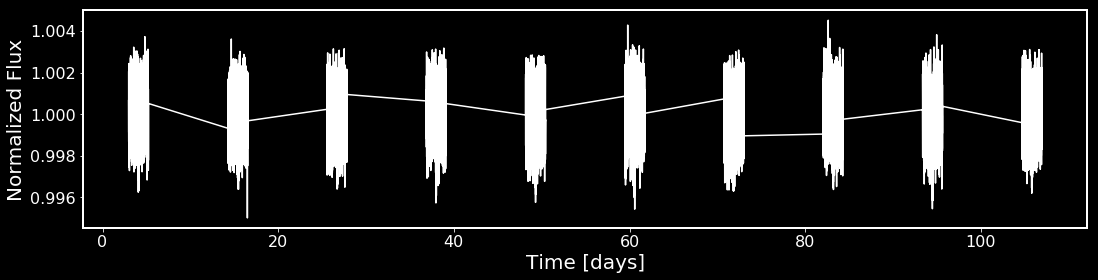

In [25]:
# simulate lightcurve
time = np.arange(TMIN, TMAX, SCIT/3600/24)
flux = np.ones_like(time) + 1e-6*NOISE_PPM*np.random.normal(size=len(time))
error = 1e-6*NOISE_PPM*np.ones_like(flux)

tts_kep = t0 + np.arange(10)*per
tts_sin = tts_kep + Attv*np.sin(tts_kep*2*pi/Pttv)

keep = np.zeros(len(time), dtype='bool')
for tc in tts_kep:
    keep[np.abs(time-tc) < per/10] = True
    
time = time[keep]
flux = flux[keep]
error = error[keep]


exoSLC = exo.LimbDarkLightCurve(u)

# here's a nice Keplerian model for easy phase-folding and plotting
nice_orbit = exo.orbits.KeplerianOrbit(period=per, t0=t0, b=b)
nice_flux  = flux + np.sum(exoSLC.get_light_curve(orbit=nice_orbit, r=rp, t=time).eval(), axis=-1)

# here's the true TTV model
orbit = exo.orbits.TTVOrbit(transit_times=[tts_sin], b=b)
flux += np.sum(exoSLC.get_light_curve(orbit=orbit, r=rp, t=time).eval(), axis=-1)


plt.figure(figsize=(18,4))
plt.plot(time, flux, 'w')
plt.xlabel('Time [days]', fontsize=20)
plt.ylabel('Normalized Flux', fontsize=20)
plt.show()

In [26]:
# fit Keplerian (incorrect) model
with pm.Model() as kep_model:
    # stellar parameters (limb darkening using Kipping 2013)
    #u = exo.distributions.QuadLimbDark('u', testval=np.array([U1,U2]))
    flux0_ = pm.Normal('flux0_', mu=1.0, sd=0.01)
    
    # planetary parameters (impact parameter using Espinoza 2018)
    per_ = pm.Normal('per_', mu=per, sd=0.1)
    t0_ = pm.Normal('t0_', mu=t0, sd=0.1)

    logr_ = pm.Uniform('logr_', lower=np.log(0.0003), upper=np.log(0.3), testval=np.log(rp))
    rp_ = pm.Deterministic('rp_', T.exp(logr_))
    b_ = exo.distributions.ImpactParameter('b_', ror=rp_, testval=b)
    
    # set up orbit and lightcurve
    exoSLC = exo.LimbDarkLightCurve(u)
    orbit = exo.orbits.KeplerianOrbit(period=per_, t0=t0_, b=b_)
    
    light_curves = exoSLC.get_light_curve(orbit=orbit, r=rp_, t=time)
    model_flux = pm.Deterministic('model_flux', pm.math.sum(light_curves, axis=-1) + flux0_*T.ones(len(time)))
    
    obs = pm.Normal("obs", mu=model_flux, sd=error, observed=flux)

with kep_model:
    kep_map = exo.optimize(start=kep_model.test_point)
    
with kep_model:
    kep_trace = pm.sample(tune=2000, draws=1000, start=kep_map, chains=2,
                          step=exo.get_dense_nuts_step(target_accept=0.9))

/Users/research/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [b_, logr_, t0_, per_, flux0_]
0it [00:00, ?it/s]/Users/research/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
55it [00:00, 248.17it/s, logp=1.817589e+05]/Users/research/anaconda3/lib/python3.7/site-packages/theano/tensor/subte

In [27]:
kep_b = np.median(kep_trace['b_']), np.std(kep_trace['b_'])
kep_rp = np.median(kep_trace['rp_']), np.std(kep_trace['rp_'])
kep_per = np.median(kep_trace['per_']), np.std(kep_trace['per_'])

/Users/research/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


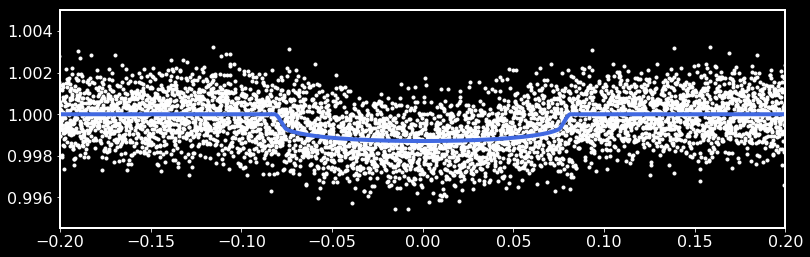

In [28]:
kep_time  = np.linspace(-0.2, 0.2, 1000)
kep_orbit = exo.orbits.KeplerianOrbit(period=kep_per[0], b=kep_b[0])
kep_flux  = 1 + np.sum(exoSLC.get_light_curve(orbit=kep_orbit, r=kep_rp[0], t=kep_time).eval(), axis=-1)

plt.figure(figsize=(13,4))
plt.plot(time % per - t0, flux, 'w.')
plt.plot(kep_time, kep_flux, 'royalblue', lw=4)
plt.xlim(-0.2,0.2)
plt.show()

In [29]:
# fit TTV (correct) model
with pm.Model() as ttv_model:
    # stellar parameters (limb darkening using Kipping 2013)
    flux0_ = pm.Normal('flux0_', mu=1.0, sd=0.01)
    
    logr_ = pm.Uniform('logr_', lower=np.log(0.0003), upper=np.log(0.3), testval=np.log(rp))
    rp_ = pm.Deterministic('rp_', T.exp(logr_))
    b_ = exo.distributions.ImpactParameter('b_', ror=rp_, testval=b)
        
    # set up orbit
    exoSLC = exo.LimbDarkLightCurve(u)
    orbit = exo.orbits.TTVOrbit(transit_times=[tts_sin], b=b_)
    
    # track period and epoch
    per_ = pm.Deterministic('per_', orbit.period)
    t0_ = pm.Deterministic('t0_', orbit.t0)

    # compute lightcurve
    light_curves = exoSLC.get_light_curve(orbit=orbit, r=rp_, t=time)
    model_flux = pm.Deterministic('model_flux', pm.math.sum(light_curves, axis=-1) + flux0_*T.ones(len(time)))
    
    obs = pm.Normal("obs", mu=model_flux, sd=error, observed=flux)

    
with ttv_model:
    ttv_map = exo.optimize(start=ttv_model.test_point)
    
    
with ttv_model:
    ttv_trace = pm.sample(tune=2000, draws=1000, start=ttv_map, chains=2,
                          step=exo.get_dense_nuts_step(target_accept=0.9))

/Users/research/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [b_, logr_, flux0_]
0it [00:00, ?it/s]/Users/research/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
70it [00:00, 378.08it/s, logp=1.819487e+05]/Users/research/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:219

In [30]:
ttv_b = np.median(ttv_trace['b_']), np.std(ttv_trace['b_'])
ttv_rp = np.median(ttv_trace['rp_']), np.std(ttv_trace['rp_'])
ttv_per = np.median(ttv_trace['per_']), np.std(ttv_trace['per_'])

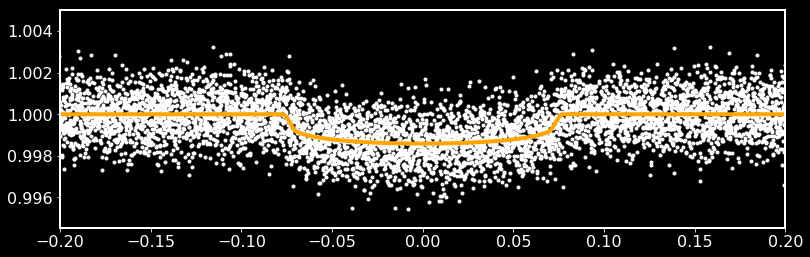

In [31]:
ttv_time  = np.linspace(-0.2, 0.2, 1000)
ttv_orbit = exo.orbits.KeplerianOrbit(period=ttv_per[0], b=ttv_b[0])
ttv_flux  = 1 + np.sum(exoSLC.get_light_curve(orbit=ttv_orbit, r=ttv_rp[0], t=ttv_time).eval(), axis=-1)

plt.figure(figsize=(13,4))
plt.plot(time % per - t0, nice_flux, 'w.')
plt.plot(ttv_time, ttv_flux, 'orange', lw=4)
plt.xlim(-0.2,0.2)
plt.show()

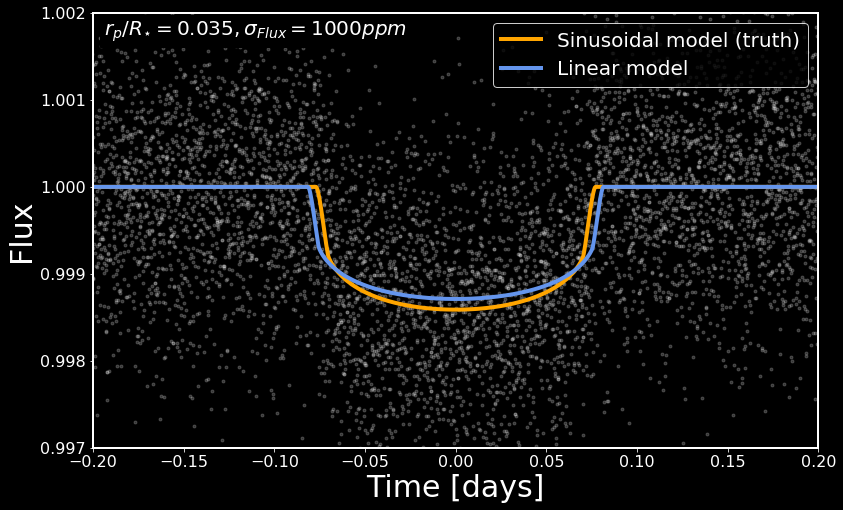

In [59]:
plt.figure(figsize=(13,8))
plt.plot(time % per - t0, nice_flux, 'w.', alpha=0.2)
plt.plot(ttv_time, ttv_flux, 'orange', lw=4, label='Sinusoidal model (truth)')
plt.plot(kep_time, kep_flux, 'cornflowerblue', lw=4, ls='-', label='Linear model')
plt.text(-0.194, 1.00165, "$r_p/R_{\star} = 0.035, \sigma_{Flux}=1000ppm$", ha='left', va='bottom', fontsize=20,
         bbox=dict(edgecolor='k', facecolor='k'))
plt.xlabel("Time [days]")
plt.xlim(-0.2,0.2)
plt.ylabel("Flux")
plt.ylim(0.997,1.002)
plt.legend(loc="upper right", facecolor='k', edgecolor='w', framealpha=0.8, frameon=True)
plt.savefig("/Users/research/Desktop/Phase_folding.pdf", bbox_inches="tight")
plt.show()

In [50]:
plt.legend?

In [106]:
kep_b, ttv_b

((0.27120587033188714, 0.04440793212938277),
 (0.4818064434751784, 0.012385741178913154))

In [107]:
kep_rp, ttv_rp

((0.03219911344382913, 0.00035606072217256665),
 (0.03489582304534555, 0.0003403483392647534))